# 🔰PyTorchでニューラルネットワーク基礎 #10 【時系列分析・指標計算】

## 内容
* Qiitaの記事と連動しています
* [9.5回指標の説明](https://qiita.com/AzukiImo/items/e02f9ec2422cddf01e46)で紹介した6種類を実際に計算するのが目的となります
* モデルの詳細については、[第8回](https://qiita.com/AzukiImo/items/516513f79d4612387418)を参照


## データについて
* データ：data/nikkei_225.csv
* 2021年から2025年6月中旬くらいのデータ
* 日経225データはyfinanceを利用して取得

## ちょっとした注意点
* CPUでもできるけどGPU（ゲーム用ノートPC搭載のGPUでもOK）あると高速に学習できる
* Google ColaboratoryでももちろんOK


In [1]:
import pandas as pd
import numpy as np

In [2]:
# CSVファイルの読み込み
data = pd.read_csv("./data/nikkei_225.csv")
data.head(5)

,Date,Open,High,Low,Close,Volume
0,2021-01-04,27575.57,27602.11,27042.32,27258.38,51500000
1,2021-01-05,27151.38,27279.78,27073.46,27158.63,55000000
2,2021-01-06,27102.85,27196.40,27002.18,27055.94,72700000
3,2021-01-07,27340.46,27624.73,27340.46,27490.13,98900000
4,2021-01-08,27720.14,28139.03,27667.75,28139.03,84900000


In [3]:
scaling_factor = 10_000
x_open = data["Open"]/scaling_factor

In [4]:
win_size = 5
XO = [x_open[start:start+win_size] for start in range(len(data)-win_size)]
T = x_open[win_size:]

xo = np.array(XO)
t  = np.array(T)
xo = xo.reshape(xo.shape[0], xo.shape[1], 1)
x = xo


## 3. LSTMを利用したネットワークの作成と学習

In [5]:
import torch
import torch.nn as nn

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")
x = torch.FloatTensor(x).to(device)
t = torch.FloatTensor(t).to(device).view(-1,1)

period = 100
x_train = x[:-period]
x_test = x[-period:]
t_train = t[:-period]
t_test = t[-period:]

x_train.shape, x_test.shape, t_train.shape, t_test.shape

device: cuda


(torch.Size([987, 5, 1]),
 torch.Size([100, 5, 1]),
 torch.Size([987, 1]),
 torch.Size([100, 1]))

In [7]:
## モデル定義
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn  = nn.LSTM(input_size=1 ,hidden_size=100, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(100, 50)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        o, (h, c)  = self.rnn(x)
        #o = o[:,-1,:]  # 最後のステップの出力を利用する h[-1]
        o = h[-1]
        h = self.fc1(o)
        h = self.act1(h)
        y = self.fc2(h)
        return y

In [8]:
model = DNN()
model.to(device)

DNN(
  (rnn): LSTM(1, 100, batch_first=True)
  (fc1): Linear(in_features=100, out_features=50, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)

In [9]:
# ハイパーパラメータ
LOOP = 8_000 # 1000

In [10]:
# 損失関数と最適化関数の定義
criterion = nn.MSELoss() # 平均二乗誤差
optimizer = torch.optim.AdamW(model.parameters())

In [11]:
# 学習ループ
model.train()
for epoch in range(LOOP):
    optimizer.zero_grad()
    y = model(x_train)
    loss = criterion(y,t_train)
    if (epoch+1)%1000 == 0:
        print(epoch,"\tloss:", loss.item())
    loss.backward()           # 逆伝播微分
    optimizer.step()          # パラメータ更新

999 	loss: 0.0034433004911988974
1999 	loss: 0.0024799774400889874
2999 	loss: 0.00187487353105098
3999 	loss: 0.0015224369708448648
4999 	loss: 0.0013342815218493342
5999 	loss: 0.0013017618330195546
6999 	loss: 0.0013619709061458707
7999 	loss: 0.0012952890247106552


# テスト用データを使って検証
* xをtrainとtestで分割した。
* x_train = x[:-period]
* x_test = x[-period:]

* x_testとt_testを利用して、検証を行う。これは実際に学習されていないデータなので面白そう！

In [13]:
import matplotlib.pyplot as plt
import japanize_matplotlib

In [14]:
model.eval()
y_test = model(x_test)

prediction = y_test.detach().cpu().numpy()
real = t_test.detach().cpu().numpy()
y_train = t_train.detach().cpu().numpy()

## テストデータと予測値のグラフ描画

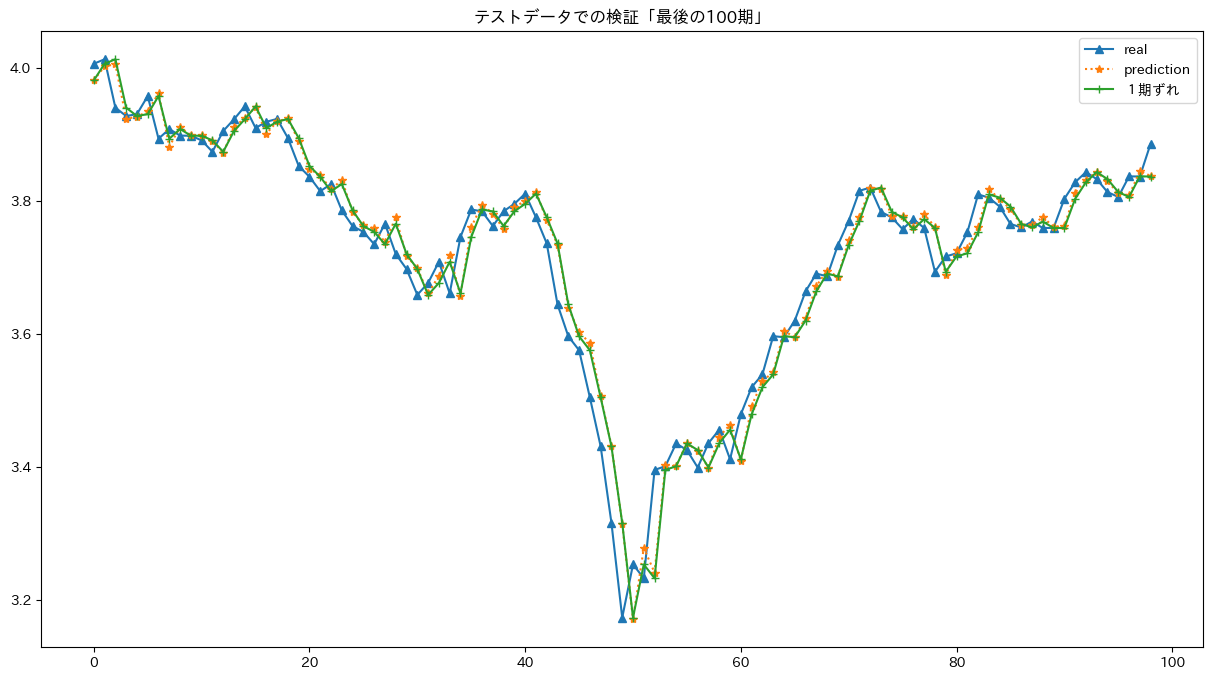

In [15]:
e = period

plt.figure(figsize=(15,8))
plt.plot(real[1:e], label="real", marker="^")
plt.plot(prediction[1:e], label="prediction", linestyle="dotted", marker="*")
plt.plot(real[:e-1], label="１期ずれ", marker="+")
plt.legend()
name = f"テストデータでの検証「最後の{period}期」"
plt.title(name)
plt.show()

# いろんな指標でチェックしてみた
* ここからが本題
  

In [16]:
# 予測結果の評価
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error

mse = mean_squared_error(real, prediction)
rmse = root_mean_squared_error(real, prediction)
mae = mean_absolute_error(real, prediction)
mape = mean_absolute_percentage_error(real, prediction)
r2 = r2_score(real, prediction)

print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse: .6f}")
print(f"MAE: {mae:.6f}")
print(f"MAPE: {mape: .6f} ({mape*100:.3f}%)")
print(f"R²: {r2:.6f}")

MSE: 0.001739
RMSE:  0.041701
MAE: 0.030649
MAPE:  0.008438 (0.844%)
R²: 0.944855


## 方向性精度

In [17]:
import numpy as np

# Direction Accuracy
def direction_accuracy(y_true, y_pred):
    # 前日からの変化方向を計算
    true_direction = np.sign(np.diff(y_true.flatten()))
    pred_direction = np.sign(np.diff(y_pred.flatten()))
    
    # 方向が一致した割合
    accuracy = np.mean(true_direction == pred_direction)
    return accuracy

In [19]:
# 計算
dir_acc = direction_accuracy(real, prediction)
print(f"Direction Accuracy: {dir_acc:.3f} ({dir_acc*100:.1f}%)")


Direction Accuracy: 0.586 (58.6%)


## モデルの比較 MASEとDiebold Mariano検定

> pip install dieboldmariano


In [21]:
def mase(y_true, y_pred, y_train):
    # 予測のMAE
    mae_pred = np.mean(np.abs(y_true - y_pred))  
    # 素朴予測のMAE（前期の値を使用）
    mae_naive = np.mean(np.abs(y_train[1:] - y_train[:-1]))
    
    return mae_pred / mae_naive

In [22]:
mase_model = mase(real, prediction, y_train)
mase_model

1.125741

In [23]:
mase_naive = mase(real[1:],real[:-1], y_train)
mase_naive

1.153

## Diebold Mariano検定

In [24]:
from dieboldmariano import dm_test

actual = real[1:].reshape(-1)          # 実測値
f_model = prediction[1:].reshape(-1)   # モデルでの予測値
s_model = real[:-1].reshape(-1)        # ナイーブモデルでの予測値

# テストを実行
dm, p_value = dm_test(actual, f_model, s_model)

print(f"DM統計量: {dm:.5f}")
print(f"p値: {p_value:.5f}")
print(f"有意水準5%で差があるか: {'Yes' if p_value < 0.05 else 'No'}")

DM統計量: -0.53557
p値: 0.59347
有意水準5%で差があるか: No
